In [1]:
import pandas as pd

In [2]:
df1 = pd.read_csv("pedestrians/crosswalk.csv")
df2 = pd.read_csv("pedestrians/fourway.csv")
df3 = pd.read_csv("pedestrians/night.csv")
#df = pd.concat([df1, df2, df3], axis=0, ignore_index=True)
df1.head(3)

len(df1)

378

In [3]:
def get_s_r(df):
    df['s'] =  df['w'] * df['h']    #scale is just area
    df['r'] = df['w'] / df['h']     # ratio
    df.drop(['w', 'h'], axis=1, inplace=True) #drop w and h columns as we won't need them
    return df

In [4]:
#df = get_s_r(df)
df1 = get_s_r(df1)
df2 = get_s_r(df2)
df3 = get_s_r(df3)

In [5]:
df1.head(3)

,x,y,s,r
0,1074,499,2775,0.493333
1,1072,499,2926,0.493506
2,1068,497,3362,0.500000


In [7]:
df1["delta_x"] = df1["x"].diff()
df1["delta_y"] = df1["y"].diff()
df1["delta_s"] = df1["s"].diff()
df1["delta_r"] = df1["r"].diff()

In [8]:
df1.describe()

,x,y,s,r,delta_x,delta_y,delta_s,delta_r
count,378.000000,378.000000,378.000000,378.000000,377.000000,377.000000,377.000000,377.000000
mean,716.632275,483.986772,13388.714286,0.497953,-3.286472,-0.222812,293.137931,0.000018
std,264.399855,21.132206,17928.585691,0.002445,4.090421,1.497590,1715.405359,0.002717
min,-165.000000,410.000000,2080.000000,0.492308,-28.000000,-9.000000,-12329.000000,-0.006667
25%,607.250000,471.000000,3773.750000,0.495327,-4.000000,-1.000000,0.000000,0.000000
50%,803.000000,494.000000,5460.000000,0.500000,-2.000000,0.000000,0.000000,0.000000
75%,879.750000,500.000000,16937.250000,0.500000,-1.000000,1.000000,309.000000,0.000021
max,1074.000000,504.000000,114481.000000,0.500000,1.000000,7.000000,15606.000000,0.007463


In [11]:
import torch
import numpy as np

def get_tensor(df, min_lenght):
    df_matrix = df.to_numpy()
    df_matrix = df_matrix.transpose()  #kalmanNet shape is [state size, trajectory size]
    df_matrix = df_matrix[:,:min_lenght]  #cut all trajectories to the same size as the smaller one
    df_tensor = torch.from_numpy(df_matrix)  #get torch tensor
    print (df_tensor.shape)
    return df_tensor

In [58]:
min_lenght = min([len(df1), len(df2), len(df3)])  #min value of all datsets to cut trajectories
df1_tensor = get_tensor(df1, min_lenght)
df2_tensor = get_tensor(df2, min_lenght)
df3_tensor = get_tensor(df3, min_lenght)

print (df1_tensor.shape[0])
df1_tensor

torch.Size([4, 378])
torch.Size([4, 378])
torch.Size([4, 378])
4


tensor([[ 1.0740e+03,  1.0720e+03,  1.0680e+03,  ..., -1.5400e+02,
         -1.5700e+02, -1.6500e+02],
        [ 4.9900e+02,  4.9900e+02,  4.9700e+02,  ...,  4.1700e+02,
          4.2000e+02,  4.1500e+02],
        [ 2.7750e+03,  2.9260e+03,  3.3620e+03,  ...,  1.0215e+05,
          9.7682e+04,  1.1329e+05],
        [ 4.9333e-01,  4.9351e-01,  5.0000e-01,  ...,  5.0000e-01,
          5.0000e-01,  5.0000e-01]], dtype=torch.float64)

In [17]:
torch.normal(3, 2, size=(1, 1))

tensor([[3.0858]])

In [37]:
def increase_size(df_tensor, final_size, min_lenght):
    tensor_ones = torch.ones(final_size - df_tensor.shape[0], min_lenght) # Increase from 4 to 7 using ones
    df_increased_tensor = torch.cat((df_tensor, tensor_ones), dim = 0)
    print (df_increased_tensor.shape)
    return df_increased_tensor

In [38]:
df1_tensor = increase_size(df1_tensor, 7, min_lenght)
df2_tensor = increase_size(df2_tensor, 7, min_lenght)
df3_tensor = increase_size(df3_tensor, 7, min_lenght)

torch.Size([7, 378])
torch.Size([7, 378])
torch.Size([7, 378])


In [39]:
target = torch.stack((df1_tensor, df2_tensor, df3_tensor), dim=0)  # create the 3d tensor with trajectories
target.shape

torch.Size([3, 7, 378])

### Find state x (input) using matrix H and observation (target)

$\hat{y}_{t|t-1} = H · \hat{x}_{t|t-1}$

#### Dimensions are y[4,378], H[4,7], x[7,378]

#### To find X we would need:

$\hat{x}_{t|t-1} = H^{-1} · \hat{y}_{t|t-1}$

#### But H don't have an inverse since it's not squared:

In [11]:
H =  torch.tensor([[1, 0, 0, 0, 0, 0, 0],
                   [0, 1, 0, 0, 0, 0, 0],
                   [0, 0, 1, 0, 0, 0, 0],
                   [0, 0, 0, 1, 0, 0, 0]]).float()
try:
    input_state = torch.inverse(H).matmul(df1_tensor)
except:
    print ("Can't invert matrix")


Can't invert matrix


# Treating data as input and add noise to get target

* Add random noise to every time step 
* Add noise to random time steps




In [40]:
noise = torch.round(torch.empty(target.shape).normal_(mean=2,std=2))
input_data = torch.add(target,noise)
print ("Input data:\n", target[0][0][0:5])
print ("Noise:\n", noise[0][0][0:5])
print ("Target: \n", input_data[0][0][0:5])

Input data:
 tensor([1074., 1072., 1068., 1066., 1062.], dtype=torch.float64)
Noise:
 tensor([4., 1., 3., 2., 1.])
Target: 
 tensor([1078., 1073., 1071., 1068., 1063.], dtype=torch.float64)


In [41]:
print ("x:\n", input_data[0][0][0:5])
print ("y:\n", input_data[0][1][0:5])
print ("s: \n", input_data[0][2][0:5])
print ("r: \n", input_data[0][3][0:5])

x:
 tensor([1078., 1073., 1071., 1068., 1063.], dtype=torch.float64)
y:
 tensor([499., 506., 497., 501., 500.], dtype=torch.float64)
s: 
 tensor([2776., 2931., 3361., 3366., 3572.], dtype=torch.float64)
r: 
 tensor([1.4933, 1.4935, 0.5000, 2.5000, 5.4941], dtype=torch.float64)


<ipython-input-55-fba1e579cf08>:5: RuntimeWarning: invalid value encountered in sqrt
  w = np.sqrt(input_data[trajectory][3]*input_data[trajectory][2])


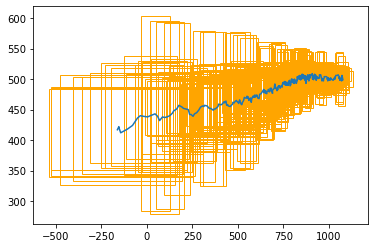

In [55]:
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

trajectory = 0
w = np.sqrt(input_data[trajectory][3]*input_data[trajectory][2])
h = input_data[trajectory][2]/w
x_bottom_left = input_data[trajectory][0] - w/2
y_bottom_left = input_data[trajectory][1] - h/2

fig, ax = plt.subplots()
ax.plot(input_data[trajectory][0], input_data[trajectory][1], label = "input", linestyle="-")

for i in range(0, input_data.shape[2]):
    step = i
    ax.add_patch(Rectangle((x_bottom_left[step], y_bottom_left[step]), w[step], h[step],color="orange", fill=False))

plt.show()

In [56]:
torch.save([target.type(torch.float32), input_data.type(torch.float32), 
            target.type(torch.float32), input_data.type(torch.float32), 
            target.type(torch.float32), input_data.type(torch.float32)], "data_as_input_add_noise_for_target.pt")

# Treating data as input and using H to get target

# Use same data for input and target

In [12]:
# import sympy
# from sympy import (init_printing, Matrix, MatMul, 
#                    integrate, symbols)

# init_printing(use_latex='mathjax')
# #dt, phi = symbols('\Delta{t} \Phi_s')

# # F_k = Matrix([[1, dt, dt**2/2],
# #               [0,  1,      dt],
# #               [0,  0,       1]])

# y = Matrix(df1_tensor.numpy())

# H =  Matrix([[1, 0, 0, 0, 0, 0, 0],
#              [0, 1, 0, 0, 0, 0, 0],
#              [0, 0, 1, 0, 0, 0, 0],
#              [0, 0, 0, 1, 0, 0, 0],
#              [0, 0, 0, 0, 0, 0, 0],
#              [0, 0, 0, 0, 0, 0, 0],
#              [0, 0, 0, 0, 0, 0, 0]])

# #Q = integrate(F_k * Q_c * F_k.T, (dt, 0, dt))

# # factor phi out of the matrix to make it more readable
# #Q = Q / phi
# MatMul(H, y)